<a href="https://colab.research.google.com/github/WeiWeiiFu/GEOL0069-London-vegetation-cover_K-means_CNN/blob/main/London_Vegetation_Cover_K_Means_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# London_Vegetation_Cover_K-Means_CNN

---



---



**Methods**: NDVI-based K-means Clustering and CNN Method

**Overview**: This notebook demonstrates how to:

1. Read and normalize the London NDVI GeoTIFF
2. Perform initial vegetation segmentation using thresholding and K-means
3. Train a lightweight U-Net CNN method




In [69]:
!git clone https://github.com/WeiWeiiFu/GEOL0069-London-vegetation-cover_K-means_CNN.git

Cloning into 'GEOL0069-London-vegetation-cover_K-means_CNN'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 10 (delta 3), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (10/10), 2.18 MiB | 14.67 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [68]:
%cd /content/drive/MyDrive/Github/

/content/drive/MyDrive/Github


In [ ]:
!pwd

/content


#  Normalized Difference Vegetation Index( NDVI)
The Normalized Difference Vegetation Index (NDVI) is a widely used metric for assessing the health and density of vegetation. It is calculated using data from the red and near-infrared bands of a remote sensing sensor, such as a satellite. NDVI values range from -1 to 1, with higher positive values indicating denser, healthier vegetation.

Calculation:
NDVI is calculated using the following formula: (NIR - RED) / (NIR + RED), where NIR is the reflectance in the near-infrared band and RED is the reflectance in the red band.

Interpretation:
Positive NDVI values (0 to 1) generally indicate vegetation, with higher values indicating more active and healthy vegetation.
Values close to 0 (or slightly negative) often represent barren areas, soil, or water.
Negative values (close to -1) are typically associated with water bodies.




In [66]:
# Prepare the data
# bands = ['B2', 'B3', 'B4', 'B8', 'NDVI']
# sample = s2_img.select(bands).sample(region=london, scale=10, numPixels=10000)
# data = sample.reduceColumns(ee.Reducer.toList(len(bands)), bands).get('list').getInfo()

# # K-means
# kmeans = KMeans(n_clusters=4, random_state=0).fit(data)
# labels = kmeans.labels_

# # (cluster 0 is vegetation)
# veg_mask = (labels == 0).astype(int)
# veg_percentage = np.mean(veg_mask) * 100
# print(f"K-means vegetation cover: {veg_percentage:.2f}%")

In [67]:
import ee
import geemap
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from tensorflow.keras import layers, models
import time
# Initializing Earth Engine
ee.Authenticate()
try:
    # ee.Initialize()
    PROJECT_ID = "silver-bird-461614-i1"   # change yourself - from first project

    ee.Initialize(project=PROJECT_ID)
except:
    !earthengine authenticate
    !earthengine create_project
    projects = ee.data.getAssetRoots()
    if projects:
        ee.Initialize(project=projects[0]['id'].split('/')[-1])
    else:
        ee.Initialize(project="london-veg-analysis")

# Define the London area (bounding box)
london_bbox = ee.Geometry.BBox(-0.510, 51.286, 0.334, 51.691)

# Get Sentinel-2 data
def get_s2_data(year):
    collection = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                  .filterBounds(london_bbox)
                  .filterDate(f'{year}-06-01', f'{year}-09-30')
                  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)))
    return collection.median().clip(london_bbox)

s2_img = get_s2_data(2023)

# Calculating NDVI
def add_ndvi(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands(ndvi)

s2_img = add_ndvi(s2_img)

# Visualization function
def plot_layer(image, vis_params, title):
    Map = geemap.Map()
    Map.add_layer(image, vis_params, title)
    Map.centerObject(london_bbox, 10)
    return Map

#
rgb_params = {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}
plot_layer(s2_img, rgb_params, "True Color")

# NDVI
ndvi_params = {'bands': ['NDVI'], 'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']}
map = plot_layer(s2_img, ndvi_params, "NDVI")
map




Map(center=[51.488452606411784, -0.08799999999975038], controls=(WidgetControl(options=['position', 'transpare…

In [62]:
!pip install rasterio

In [63]:
import rasterio

with rasterio.open('/content/drive/MyDrive/London_NDVI.tif') as src:
    #
    ndvi_arr = src.read(1)

    #
    print("Number of bands:", src.count)
    print("Image size:", src.height, "x", src.width)
    print("Data Types:", src.dtypes[0])
    print("Coordinate reference system(CRS):", src.crs)

#
ndvi_arr = np.squeeze(ndvi_arr)
print("The shape of the processed array:", ndvi_arr.shape)


Number of bands: 1
Image size: 452 x 940
Data Types: float32
Coordinate reference system(CRS): EPSG:4326
The shape of the processed array: (452, 940)


In [64]:

import numpy as np
import matplotlib.pyplot as plt
import rasterio
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

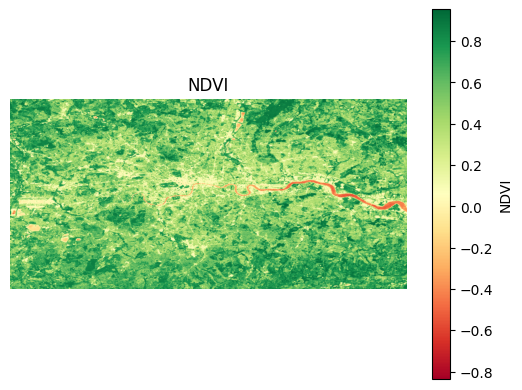

In [65]:

# Reading NDVI Images
with rasterio.open("/content/drive/MyDrive/London_NDVI.tif") as src:
    ndvi_arr = src.read(1)

plt.imshow(ndvi_arr, cmap='RdYlGn')
plt.title("NDVI")
plt.colorbar(label="NDVI")
plt.axis('off')
plt.show()

# K-Means
K-means clustering is a type of unsupervised learning algorithm used for partitioning a dataset into a set of k groups (or clusters), where k represents the number of groups pre-specified by the analyst. It classifies the data points based on the similarity of the features of the data. The basic idea is to define k centroids, one for each cluster, and then assign each data point to the nearest centroid, while keeping the centroids as small as possible.

Advantages of K-means:

Efficiency: K-means is computationally efficient.
Ease of interpretation: The results of k-means clustering are easy to understand and interpret.



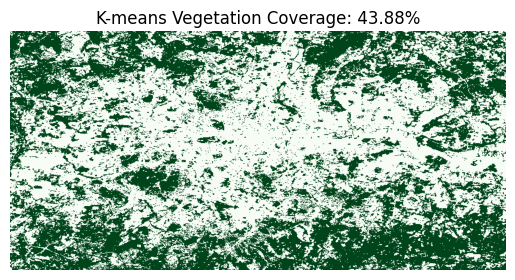

K-means London vegetation coverage: 43.88%


In [59]:

# def threshold_vegetation(ndvi, thresh=0.4):
#     vegetation = ndvi > thresh
#     coverage = np.mean(vegetation) * 100
#     plt.imshow(vegetation, cmap='Greens')
#     plt.title(f'Threshold Vegetation (Coverage: {coverage:.2f}%)')
#     plt.axis('off')
#     plt.show()
#     return coverage

# thresh_coverage = threshold_vegetation(ndvi_arr)

# K-means method
def kmeans_segmentation(img_array, n_clusters=3):
    rows, cols = img_array.shape
    reshaped = img_array.reshape(-1, 1)

    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(reshaped)
    clustered = kmeans.labels_.reshape(rows, cols)

    #
    cluster_means = [np.mean(img_array[clustered == i]) for i in range(n_clusters)]
    vegetation_cluster = np.argmax(cluster_means)

    vegetation_mask = (clustered == vegetation_cluster)
    coverage = np.mean(vegetation_mask) * 100

    plt.imshow(vegetation_mask, cmap='Greens')
    plt.title(f'K-means Vegetation Coverage: {coverage:.2f}%')
    plt.axis('off')
    plt.show()
    return coverage

kmeans_coverage = kmeans_segmentation(ndvi_arr)


print(f"K-means London vegetation coverage: {kmeans_coverage:.2f}%")

 London vegetation cover：43.67%


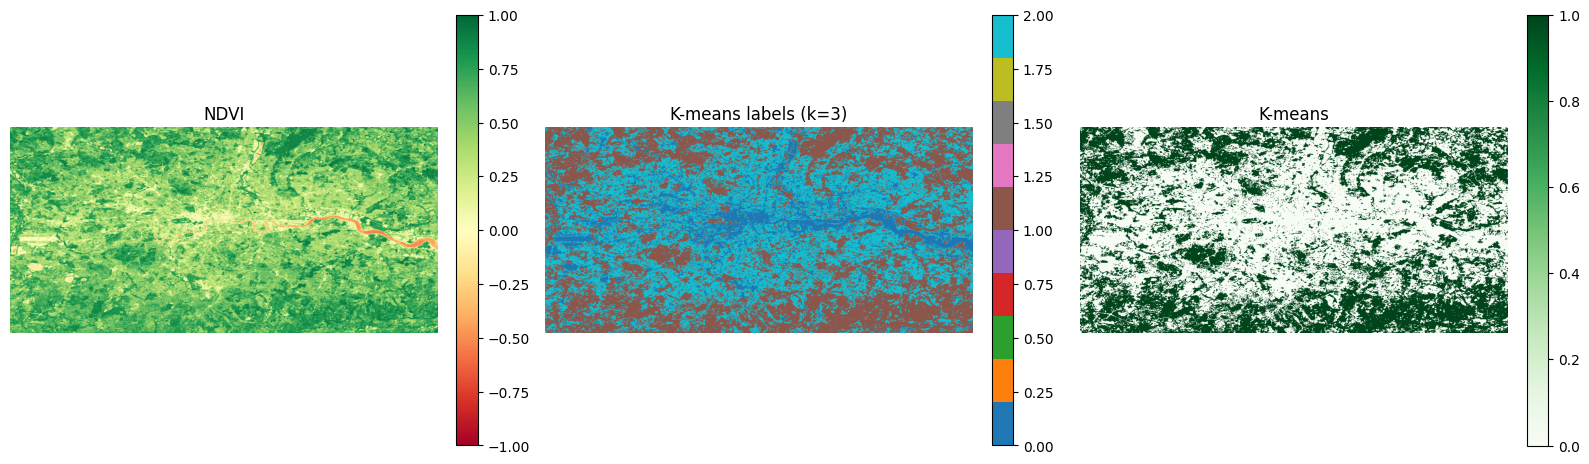

In [60]:
import rasterio, numpy as np
from sklearn.cluster import KMeans

ndvi_path = '/content/drive/MyDrive/London_NDVI.tif'
with rasterio.open(ndvi_path) as src:
    ndvi = src.read(1).astype('float32')

#
if ndvi.max() > 1.2 or ndvi.min() < -1.2:
    ndvi /= 10000.0
ndvi = np.clip(ndvi, -1, 1)


# ndvi[roi_mask == 0] = np.nan

# 3) K-means
X = ndvi.reshape(-1, 1)
kmeans = KMeans(
    n_clusters=3,
    n_init=20,
    random_state=42
).fit(X)

labels = kmeans.labels_.reshape(ndvi.shape)
cluster_means = [ndvi[labels == i].mean() for i in range(3)]
veg_cluster = int(np.argmax(cluster_means))

veg_mask  = (labels == veg_cluster)
coverage  = np.nanmean(veg_mask) * 100
print(f" London vegetation cover：{coverage:.2f}%")

import matplotlib.pyplot as plt
import numpy as np


# ndvi
# labels
# veg_mask
# kmeans

fig, ax = plt.subplots(1, 3, figsize=(16, 5))

# ① NDVI
im0 = ax[0].imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)
ax[0].set_title('NDVI', fontsize=12)
fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

# ② K-means labels
im1 = ax[1].imshow(labels, cmap='tab10')
ax[1].set_title(f'K-means labels (k={kmeans.n_clusters})', fontsize=12)
fig.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

# ③ K- means London vegetation cover
im2 = ax[2].imshow(veg_mask, cmap='Greens')
ax[2].set_title('K-means', fontsize=12)
fig.colorbar(im2, ax=ax[2], fraction=0.046, pad=0.04)

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()

# CNN-Convolutional Neural Networks
Convolutional Neural Networks, commonly known as CNNs, are a class of deep neural networks specially designed to process data with grid-like topology, such as images. Originating from the visual cortex’s biological processes, CNNs are revolutionising the way we understand and interpret visual data.

Advantages of CNNs:

Parameter Sharing: A feature detector (filter) that’s useful in one part of the image can be useful in another part of the image
Sparsity of Connections: In each layer, each output value depends only on a small number of input values, making the computation more efficient.

Epoch 1/3
797/797 ━━━━━━━━━━━━━━━━━━━━ 849s 1s/step - accuracy: 0.8174 - loss: 0.3273 - mean_io_u: 0.2865 - val_accuracy: 0.9635 - val_loss: 0.0934 - val_mean_io_u: 0.2857 - learning_rate: 0.0010
Epoch 2/3
797/797 ━━━━━━━━━━━━━━━━━━━━ 850s 1s/step - accuracy: 0.9666 - loss: 0.0841 - mean_io_u: 0.2865 - val_accuracy: 0.9800 - val_loss: 0.0573 - val_mean_io_u: 0.2861 - learning_rate: 0.0010
Epoch 3/3
797/797 ━━━━━━━━━━━━━━━━━━━━ 859s 1s/step - accuracy: 0.9798 - loss: 0.0549 - mean_io_u: 0.2910 - val_accuracy: 0.9747 - val_loss: 0.0547 - val_mean_io_u: 0.2999 - learning_rate: 0.0010
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

 Vegetation cover: 40.10%


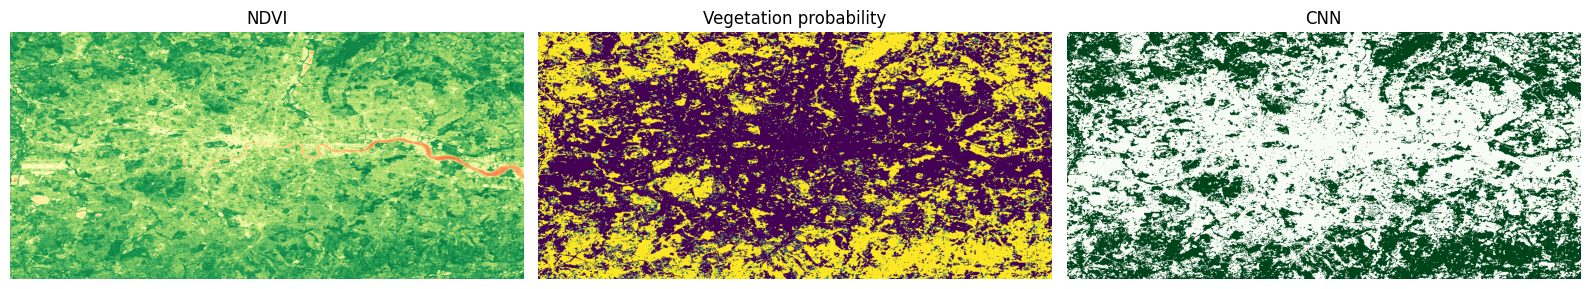

In [58]:
#London Vegetation Cover – CNN method

NDVI_PATH      = "/content/drive/MyDrive/London_NDVI.tif"
PATCHES        = 30_000
WINDOW_SIZE    = 64
BATCH_SIZE     = 32
EPOCHS_MAX     = 3
THRESH_VEG     = 0.60
SEED           = 42


# 1. Imports & reproducibility

import os
import numpy as np
import rasterio
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models

np.random.seed(SEED)
tf.random.set_seed(SEED)

# 2. Load & normalise NDVI raster
with rasterio.open(NDVI_PATH) as src:
    ndvi      = src.read(1).astype(np.float32)
    ndvi_meta = src.profile

if ndvi.max() > 1.2 or ndvi.min() < -1.2:
    ndvi /= 10_000.0
ndvi = np.clip(ndvi, -1.0, 1.0)
ndvi_norm = (ndvi + 1.0) / 2.0

# 3. Weak labels

veg_mask = (ndvi > THRESH_VEG).astype(np.float32)


# 4. Patch sampler


def extract_patches(img, msk, win=64, n=30_000):
    h, w = img.shape; pad = win//2
    img_p = np.pad(img, pad, mode="reflect"); msk_p = np.pad(msk, pad, mode="reflect")
    X = np.empty((n, win, win, 1), np.float32)
    y = np.empty_like(X)
    for k in range(n):
        i = np.random.randint(pad, h+pad); j = np.random.randint(pad, w+pad)
        X[k,...,0] = img_p[i-pad:i+pad, j-pad:j+pad]
        y[k,...,0] = msk_p[i-pad:i+pad, j-pad:j+pad]
    return X, y

X, y = extract_patches(ndvi_norm, veg_mask, WINDOW_SIZE, PATCHES)
strat = (y.mean(axis=(1,2,3)) > 0.10)
X_tr, X_va, y_tr, y_va = train_test_split(X, y, test_size=0.15, stratify=strat, random_state=SEED)


# 5. Tiny U‑Net (dynamic) – clear old graph first


# wipe previous graphs (prevents shape lock-in during iterative editing)
tf.keras.backend.clear_session()

def unet_small():
    """Fully‑convolutional U‑Net that ingests any H×W×1; depths=2."""
    inp = layers.Input(shape=(None, None, 1))
    # Down 1
    c1 = layers.Conv2D(32,3,padding='same',activation='relu')(inp)
    p1 = layers.MaxPool2D()(c1)
    # Bottleneck
    c2 = layers.Conv2D(64,3,padding='same',activation='relu')(p1)
    # Up 1
    u1  = layers.UpSampling2D()(c2)
    m1  = layers.Concatenate()([u1, c1])
    c3  = layers.Conv2D(32,3,padding='same',activation='relu')(m1)
    out = layers.Conv2D(1,1,activation='sigmoid')(c3)
    return models.Model(inp, out, name="unet_small_dyn")

model = unet_small()


# 6. Loss & compile (broadcast‑safe)


def dice_loss(y_true, y_pred, smooth=1.):
    y_true = tf.cast(y_true, tf.float32)
    inter  = tf.reduce_sum(y_true * y_pred, axis=[1,2,3])
    union  = tf.reduce_sum(y_true + y_pred, axis=[1,2,3])
    return 1. - (2.*inter + smooth) / (union + smooth)


def combined_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    # BCE per‑pixel ➜ reduce to (batch,)
    bce_map = tf.keras.backend.binary_crossentropy(y_true, y_pred)
    bce     = tf.reduce_mean(bce_map, axis=[1,2,3])
    dice    = dice_loss(y_true, y_pred)
    return 0.6*bce + 0.4*dice

model.compile(optimizer='adam', loss=combined_loss,
              metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)])

# 7. Training

callbacks=[tf.keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True),
           tf.keras.callbacks.ReduceLROnPlateau(patience=3)]

history = model.fit(X_tr, y_tr,
                    validation_data=(X_va, y_va),
                    epochs=EPOCHS_MAX,
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks,
                    verbose=1)

# 8. Full‑image inference & coverage

prob = model.predict(ndvi_norm[None,...,None], batch_size=1)[0,...,0]
mask = (prob > 0.5).astype(np.uint8)
print(f"\n Vegetation cover: {mask.mean()*100:.2f}%")


# 9. Save GeoTIFF

meta = ndvi_meta.copy(); meta.update(dtype=rasterio.uint8, count=1)
with rasterio.open("London_veg_mask_cnn.tif", "w", **meta) as dst:
    dst.write(mask, 1)

# 10. print

if __name__ == "__main__":
    try:
        import matplotlib.pyplot as plt
        fig, ax = plt.subplots(1,3,figsize=(16,5))
        ax[0].imshow(ndvi, cmap='RdYlGn', vmin=-1,vmax=1); ax[0].set_title('NDVI'); ax[0].axis('off')
        ax[1].imshow(prob, cmap='viridis', vmin=0,vmax=1); ax[1].set_title('Vegetation probability'); ax[1].axis('off')
        ax[2].imshow(mask, cmap='Greens'); ax[2].set_title('CNN'); ax[2].axis('off')
        plt.tight_layout(); plt.show()
    except Exception:
        pass
